**Gesture Recognition**

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.




In [3]:
import numpy as np
import os

from skimage.io import imread

from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
batch_size = 10

**Generator**

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [6]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):
                    #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    norm = resize(image,(120,120))
                    norm = norm/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (norm[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (norm[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (norm[:,:,2]) #normalise and feed in the image
                  
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                        norm = resize(image,(120,120))
                        norm = norm/255 #Normalize data
                    
                        batch_data[folder,idx,:,:,0] = (norm[:,:,0])
                        batch_data[folder,idx,:,:,1] = (norm[:,:,1])
                        batch_data[folder,idx,:,:,2] = (norm[:,:,2])
                  
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


**Model**

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras

#write your model here
#model a
model_a = Sequential()

model_a.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(64, #Number pf filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_a.add(Flatten())

model_a.add(Dense(1000, activation='relu'))
model_a.add(Dropout(0.5))

model_a.add(Dense(500, activation='relu'))
model_a.add(Dropout(0.5))

#softmax layer
model_a.add(Dense(5, activation='softmax'))

2023-07-05 11:34:31.238474: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-05 11:34:31.238549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [9]:
from tensorflow.keras import optimizers

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_a.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 8)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_1 (Batc  (None, 15, 60, 60, 16)   6

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
model_a.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_303/1387693686.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_a.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  datasets/Project_data/train ; batch size = 10
Epoch 1/5


2023-07-05 11:34:41.454592: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 4.8909 - categorical_accuracy: 0.3152Source path =  datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2023-07-0511_34_28.869952/model-00001-4.89088-0.31523-1.65593-0.27000.h5
67/67 [==============================] - 154s 2s/step - loss: 4.8909 - categorical_accuracy: 0.3152 - val_loss: 1.6559 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/5
67/67 [==============================] - ETA: 0s - loss: 2.5848 - categorical_accuracy: 0.2637
Epoch 00002: saving model to model_init_2023-07-0511_34_28.869952/model-00002-2.58483-0.26368-1.58375-0.24000.h5
67/67 [==============================] - 62s 938ms/step - loss: 2.5848 - categorical_accuracy: 0.2637 - val_loss: 1.5838 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/5
67/67 [==============================] - ETA: 0s - loss: 1.8993 - categorical_accuracy: 0.2935
Epoch 00003: saving model to model_init_2023-07-0511_34_28.869952/model-00

Since the above model is underfitting, we have to create more models to get the best accuracy. 

**Model 2**

For this model we have changed the number of epochs to 10 and we have added few dropout layers to make the model fit.

In [14]:
num_epochs = 10

In [15]:

from keras.losses import categorical_crossentropy


# Define model b
model_b = Sequential()
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(x,y,z,3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Flatten())
model_b.add(Dense(512, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(5, activation='softmax'))





In [16]:
from tensorflow.keras import optimizers

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_b.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_b.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 32)  2624      
                                                                 
 activation_4 (Activation)   (None, 30, 120, 120, 32)  0         
                                                                 
 conv3d_5 (Conv3D)           (None, 30, 120, 120, 32)  27680     
                                                                 
 activation_5 (Activation)   (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 40, 40, 32)   0         
 3D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 10, 40, 40, 32)    0         
                                                      

In [17]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [18]:
model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_303/3161962229.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  datasets/Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.7616 - categorical_accuracy: 0.1991Source path =  datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2023-07-0511_34_28.869952/model-00001-1.76156-0.19910-1.60857-0.23000.h5
67/67 [==============================] - 160s 2s/step - loss: 1.7616 - categorical_accuracy: 0.1991 - val_loss: 1.6086 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.6088 - categorical_accuracy: 0.1990
Epoch 00002: saving model to model_init_2023-07-0511_34_28.869952/model-00002-1.60876-0.19900-1.60874-0.26000.h5
67/67 [==============================] - 68s 1s/step - loss: 1.6088 - categorical_accuracy: 0.1990 - val_loss: 1.6087 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.6114 - categorical_accuracy: 0.1791
Epo

**Model 3**

In this model we are taking the number of epochs as 20 and batch.

In [19]:
model_c = Sequential()
model_c.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(x,y,z,3), padding="same"))
model_c.add(Activation('relu'))
model_c.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
model_c.add(Activation('relu'))
model_c.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model_c.add(Dropout(0.25))

model_c.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model_c.add(Activation('relu'))
model_c.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model_c.add(Activation('relu'))
model_c.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model_c.add(Dropout(0.25))

model_c.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model_c.add(Activation('relu'))
model_c.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model_c.add(Activation('relu'))
model_c.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model_c.add(Dropout(0.25))

model_c.add(Flatten())
model_c.add(Dense(512, activation='relu'))
model_c.add(BatchNormalization())
model_c.add(Dropout(0.5))
model_c.add(Dense(5, activation='softmax'))

In [20]:
from tensorflow.keras import optimizers

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_c.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_c.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 32)  2624      
                                                                 
 activation_8 (Activation)   (None, 30, 120, 120, 32)  0         
                                                                 
 conv3d_9 (Conv3D)           (None, 30, 120, 120, 32)  27680     
                                                                 
 activation_9 (Activation)   (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 10, 40, 40, 32)   0         
 3D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 10, 40, 40, 32)    0         
                                                      

In [21]:
# Changing back batch size, images per frame, height and width of image
batch_size = 10
x = 30 # number of frames
y = 120 # image width
z = 120# image height
num_epochs = 20

In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
 model_a.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_303/1535847109.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_a.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.1596 - categorical_accuracy: 0.5008Source path =  datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2023-07-0511_34_28.869952/model-00001-1.15957-0.50075-1.65785-0.29000.h5
67/67 [==============================] - 155s 2s/step - loss: 1.1596 - categorical_accuracy: 0.5008 - val_loss: 1.6579 - val_categorical_accuracy: 0.2900 - lr: 5.0000e-04
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1903 - categorical_accuracy: 0.4776
Epoch 00002: saving model to model_init_2023-07-0511_34_28.869952/model-00002-1.19027-0.47761-1.35372-0.38000.h5
67/67 [==============================] - 64s 973ms/step - loss: 1.1903 - categorical_accuracy: 0.4776 - val_loss: 1.3537 - val_categorical_accuracy: 0.3800 - lr: 5.0000e-04
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.1331 - categorical_accuracy:

**FINAL MODEL**

In [24]:
filters = [8,16,32,64]
dense = [256, 128, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model_final = Sequential()

model_final.add(Conv3D(filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_final.add(Activation('relu'))
model_final.add(Dropout(0.25))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_final.add(Flatten())

model_final.add(Dense(dense[0], activation='relu'))
model_final.add(Dropout(0.5))

model_final.add(Dense(dense[1], activation='relu'))
model_final.add(Dropout(0.5))

#softmax layer
model_final.add(Dense(dense[2], activation='softmax'))

In [25]:
from tensorflow.keras import optimizers

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_final.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_final.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_5 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_14 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 15, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_15 (Conv3D)          (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_6 (Batc  (None, 15, 60, 60, 16)  

In [26]:
batch_size = 40
num_epochs = 20

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



In [27]:
mf = model_final.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_303/1276821829.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  mf = model_final.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  datasets/Project_data/train ; batch size = 40
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.7315 - categorical_accuracy: 0.3241Source path =  datasets/Project_data/val ; batch size = 40
Batch:  3 Index: 40

Epoch 00001: saving model to model_init_2023-07-0511_34_28.869952/model-00001-1.73153-0.32406-1.64832-0.21667.h5
67/67 [==============================] - 398s 6s/step - loss: 1.7315 - categorical_accuracy: 0.3241 - val_loss: 1.6483 - val_categorical_accuracy: 0.2167 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1115 - categorical_accuracy: 0.5468
Epoch 00002: saving model to model_init_2023-07-0511_34_28.869952/model-00002-1.11147-0.54678-1.61263-0.28500.h5
67/67 [==============================] - 286s 4s/step - loss: 1.1115 - categorical_accuracy: 0.5468 - val_loss: 1.6126 - val_categorical_accuracy: 0.2850 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8883 - categorical

**Graph**

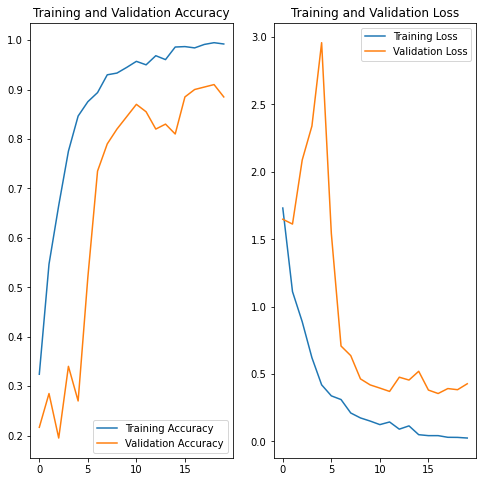

In [29]:
import matplotlib.pyplot as plt

acc = mf.history['categorical_accuracy']
val_acc = mf.history['val_categorical_accuracy']

loss = mf.history['loss']
val_loss = mf.history['val_loss']


epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:


# Save the model to an .h5 file
model_final.save('model_final.h5')